# Gradient Descent Methods

### Author: Aymeric DIEULEVEUT

### <font color='Blue'> Read the following two cells before you start clicking everywhere !! </font> :D

The aim of this material is to implement and compare several optimization methods for Least Squares Regression and Logistic Regression. We focus on the empirical risk minimization problem.

To do so we will:

| Part | Objective | What you have to code |
| :- |:- | :- |
| I. | Simulate a linear and logistic model | <font color='green'>nothing !</font>|
| II. | Create two classes: ModelLinReg and ModelLogisticReg,| <font color='orange'> Loss and gradients  for the logistic loss </font>|
|| this will allow us to access the gradients and Lipshitz/Smoothness constants of the loss functions|
|III. | Code some methods listed afterwards: GD, SGD, AGD, SVRG, etc. |  <font color='orange'> The update steps</font>|
| |only the most crucial part -- the update step  -- has to be implemented|
|IV. | Compare the methods of your choice|<font color='green'>nearly nothing: choose your methods </font> |



##### Main methods 
- gradient descent (GD)
- accelerated gradient descent (AGD)
- coordinate gradient descent (CD)
- stochastic gradient descent (SGD)
- stochastic variance reduced gradient descent (SVRG)
- optimization methods for Deep Learning

### Remarks
##### Most of the content is elementary, but serves multiple objectives ...
- hands on on the optimization methods you have encountered
- compare optimization methods (stochastic vs non-stochastic), impact of Variance reduction
- what can we read on convergence curves: deduct convergence speed from the learning curve
- how to obtain a meaningful optimization curve

##### and can be extended in **many** directions
- framework to play with hyper-parameters 
- framework to implement other methods
- back to test error: what happens?
- adapative methods, non uniform sampling in stochastic, federated learning methods, etc.

# How this lab works


## Organisation 
- Most of the content is already implemented (obviously)
- You have to complete the code when there is a blank with
````   
        #
        #
        # YOUR CODE HERE
        #
        #
````
- A  corrected version will be put online at the end 

## Interactive tool
To follow your progress, adapt correction spped, and provide better feedback, we have developped a tool with Evan Courdier at EPFL:
- At the beginning of the lab, when running the first cell, you will be able to enter your name
- Afterwards, each time a ```send``` function appears, the first argument of the send function (typically the code of your function, a value of an array, a plot, etc), is send to a server, which allows me to follwo your progress, correct some mistakes, etc.
- This is totally transparent for you. The code is OS, all results are erased afterwards. You can use a pseudo if you want (try to make it unique). 



<font color='green'> If it works: </font> you will get a <Response [200]> message after each send. Thank you for helping me give a more interactive (hopefully better) lab!
<font color='orange'> If it does not, or if really do not want to use the tool </font> Do not try debugging it :D. Just redefine the send function as:    ```def send(a,b): return()```






# Table of content

[1. Introduction](#intro)<br>

[2. Models gradients and losses](#models)<br>

[2.1  Linear regression](#models_regression)<br>
[2.2  Check for Linear regression](#models_regression_check)<br>
[2.3  Logistic regression](#models_logistic)<br>
[2.4  Check for logistic regression](#models_logistic_check)<br>


[3. Solvers](#solvers)<br>

[3.1 Tools for solvers](#tools)<br>
[3.2 Gradient descent](#gd)<br>
[3.3 Accelerated Gradient descent](#agd)<br>
[3.4 Coordinate Gradient descent](#cgd)<br>
[3.5 Stochastic Gradient descent](#sgd)<br>
[3.6 Stochastic Average Gradient descent](#sag)<br>
[3.7 Stochastic Variance Reduced Gradient descent](#svrg)<br>
[3.8 Adagrad](#adagrad)<br>
[3.9 RMSProp](#rmsprop)<br>
[3.10 AdaDelta](#adadelta)<br>
[3.11 Adam](#adam)<br>
[3.12 Adamax](#adamax)<br>

[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Getting model weights

We'll start by generating sparse vectors and simulating data

### TODO BLOCK  
- Add newton
- Add hessaien
- ajouter strong convexity

### Possible directions:
- implement newton
- add Polyak-momentum !
- look at the test loss => here only training loss
- implement the other methods (after next  lecture)

### END TODO BLOCK 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [3]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

import requests
exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)
npt_config = {
    'session_name': 'Optimization-Gradient-Methods',
    'session_owner': 'aymeric',
    'sender_name': input("Your name:"),
}
send('start', 0)    

Your name:Aymeric


<Response [200]>

In [4]:
def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

<Response [200]>

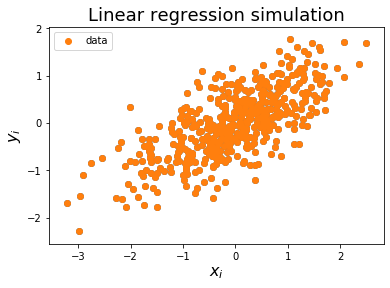

In [5]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()
send(plt, 1)

## 1.3. Simulation of a logistic regression model

In [6]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

In [7]:
u = np.array([1,2,3])
sigmoid(u)

array([0.73, 0.88, 0.95])

<Response [200]>

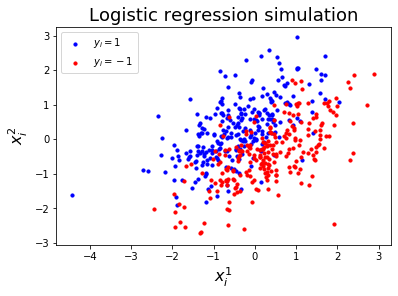

In [8]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)
send(plt, 2)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**, where 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.

Below is the full implementation for linear regression.

<a id='models_regression'></a>

## 2.1 Linear regression

In [9]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]

    def lip(self):
        """Computes the Lipschitz constant of the gradients of  f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the gradients of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradients of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()
    
    def hessian(self):
        X, n_samples = self.X, self.n_samples
        return(X.T.dot(X))/ n_samples + self.strength

<a id='models_regression_check'></a>

## 2.2 Checks for the linear regression model

/Users/dieuleve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


Text(0.5, 1.0, 'Model weights')

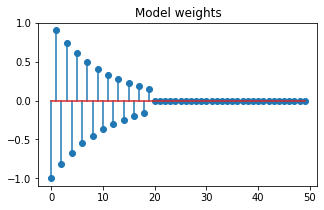

In [10]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

In [11]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)
w = np.random.randn(n_features)

send(float(check_grad(model.loss, model.grad, w)), 3)
print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

4.02584090429952e-06


In [12]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 4.119437564876499
lip_max= 106.80950856239404
lip_coordinates= [0.99 0.99 1.01 1.03 0.98 0.99 1.02 1.03 0.97 0.9  1.03 1.04 1.08 1.06
 1.07 0.95 0.98 0.98 1.01 1.04 1.01 1.01 0.96 1.   1.02 1.06 1.03 0.95
 0.96 1.01 1.05 1.06 1.03 0.95 0.97 1.01 1.1  1.02 0.95 0.92 0.98 0.98
 1.1  1.   1.01 1.05 1.08 1.02 1.04 0.98]


In [16]:
model.hessian().shape

(50, 50)

<a id='models_logistic'></a>

## 2.3 Logistic regression

**1) Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).**

**2) Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below.**

In [15]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO BLOCK
        return np.mean(np.log(1+np.exp(- y * (X.dot(w))))) + strength * norm(w) ** 2 / 2
        ### END TODO BLOCK
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO BLOCK
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X.T.dot(u))/n_samples + strength * w
       ### END TODO BLOCK
    
    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        strength = self.strength
        ### TODO BLOCK
        u = y[i]*np.exp(- y[i] * (x_i.dot(w)))/(1 + np.exp(- y[i] * (x_i.dot(w))))
        return (- u*x_i + strength * w)
        ### END TODO BLOCK
    
    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X[:, j].T.dot(u))/n_samples + strength * w[j]


    def lip(self):
        """Computes (an upper bound on) the Lipschitz constant of the gradient of  f"""
        X, n_samples = self.X, self.n_samples

        return norm(X.T.dot(X), 2) / (4*n_samples) + self.strength


    def lip_coordinates(self):
        """Computes (an upper bound on) the Lipschitz constant of the gradient of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples

        return (X ** 2).sum(axis=0) / (4*n_samples) + self.strength


    def lip_max(self):
        """Computes (an upper bound on) the maximum of the lipschitz constants of the gradients of  f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()

     
    def hessian(self):
        X, n_samples = self.X, self.n_samples
        ### TODO BLOCK
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()
        ### END TODO BLOCK
        
send(ModelLogReg.loss, 4)
send(ModelLogReg.grad, 5)
send(ModelLogReg.grad_i, 6)


<Response [200]>

<a id='models_logistic_check'></a>


## 2.4 Checks for the logistic regression model

**3) Use the function `simu_logreg` to simulate data according to the logistic regression model. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize``, as we did for linear regression above.**

/Users/dieuleve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


Checkgrad returns 1.35e-07


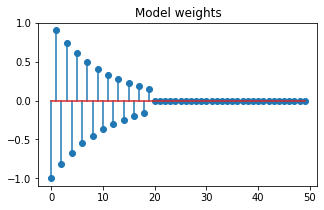

In [16]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

from scipy.optimize import check_grad



### TODO BLOCK
X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)
w = np.random.randn(n_features)
### END TODO BLOCK
send('Checkgrad returns %.2e' % (check_grad(model.loss, model.grad, w)), 7)
print('Checkgrad returns %.2e' % (check_grad(model.loss, model.grad, w))) # This must be a number (of order 1e-6)


In [17]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 1.0237015259535096
lip_max= 29.27794104389502
lip_coordinates= [0.25 0.25 0.25 0.23 0.24 0.25 0.24 0.23 0.24 0.24 0.24 0.26 0.25 0.24
 0.25 0.25 0.24 0.25 0.24 0.24 0.26 0.25 0.25 0.25 0.28 0.26 0.26 0.25
 0.23 0.25 0.25 0.26 0.26 0.26 0.26 0.27 0.24 0.26 0.25 0.25 0.25 0.25
 0.23 0.24 0.24 0.25 0.26 0.25 0.24 0.24]


<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression. We want now to code and compare several solvers to minimize $f$.

<a id='tools'></a>
## 3.1. Tools for the solvers

The following tools store the loss after each epoch

In [18]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg) 
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [19]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.6e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent


**4) Finish the function `gd` below that implements the gradient descent algorithm and test it using the next cell.**

In [20]:
def gd(model, w0, step,  n_iter, callback, verbose=True):
    """Gradient descent
    """
    #step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO BLOCK
        w_new[:] = w - step * model.grad(w)
        w[:] = w_new # Remark : does operation inplace
        ### END TODO BLOCK
        callback(w)
    return w
send(gd, 8)

<Response [200]>

### The following code runs GD and stores the objectivre values

In [21]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, step= 1/model.lip(),  n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.821132e-01
      20 | 5.548963e-01
      30 | 5.438910e-01
      40 | 5.388069e-01
      50 | 5.362730e-01


- Which step size was chosen?
- What is the expected rate of convergence?

<a id='agd'></a>
## 3.3 Accelerated gradient descent

**5) Finish the function `agd` below that implements the accelerated gradient descent algorithm and test it using the next cell.**

What choice of momentum coefficient is recommended for AGD ?
- for strongly convex
- for convex functions

Here you can make different choices:
- an arbitrary value (0.9)
- using the strong convexity
- using only convexity

In [22]:
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    mu = model.strength
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration
    z = w0.copy() # the auxiliari point at which the gradient is taken
    t = 1. # beta this morning = momentum coefficient 
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO BLOCK
        w_new[:] = z - step * model.grad(z)
        
        # Trivial choice
        # t_new = 0.9
        
        t_new = (1. + (1. + 4. * t * t) ** (0.5)) / 2. # Optimal momentum coefficinet for smooth convex
        beta = (t - 1) / t_new
        # see https://blogs.princeton.edu/imabandit/2018/11/21/a-short-proof-for-nesterovs-momentum/
        # Simpler choice:
        beta = k/(k+3)
        
        # t_new = k/k+3 (other solution in convex)
#         if mu >0 :
#             kappa = (model.lip())/(mu)
#             beta = (1-(1/kappa)**0.5 )/(1+(1/kappa)**0.5) # For strongly convex
        # see https://blogs.princeton.edu/imabandit/2014/03/06/nesterovs-accelerated-gradient-descent-for-smooth-and-strongly-convex-optimization/

        
        z[:] = w_new + beta * (w_new - w)
        t = t_new
        w[:] = w_new
        ### END TODO BLOCK        
        callback(w)
    return w

send(agd, 9)

<Response [200]>

In [23]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

Lauching AGD solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.532204e-01
      20 | 5.333628e-01
      30 | 5.337240e-01
      40 | 5.333184e-01
      50 | 5.333691e-01


<a id='cgd'></a>

## 3.4 Coordinate gradient descent

**6) Finish the function `cgd` below that implements the coordinate gradient descent algorithm and test it using the next cell.**

In [24]:
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO BLOCK
        for j in range(n_features): # 50 features
            w[j] -= steps[j] * model.grad_coordinate(j, w)  # 
        ### END TODO BLOCK
        callback(w)
    return w
send(cgd, 10)

<Response [200]>

In [25]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.342090e-01
      20 | 5.333405e-01
      30 | 5.333165e-01
      40 | 5.333157e-01
      50 | 5.333157e-01


<a id='sgd'></a>
## 3.5. Stochastic gradient descent

**7) Finish the function `sgd` below that implements the st stochastic gradient descent algorithm and test it using the next cell.**

In [26]:
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    mu = model.strength
    w = w0.copy()
    w_ave = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        ### TODO BLOCK
        w -= step * model.grad_i(
            i, w) / (np.sqrt(idx + 1))  # decays at 1/sqrt{k} good choice for convex functions
        # decent choice for strongly convex
        # also possible to use (max(mu*(idx + 1), model.lip())) (choice in the slides)

        #w_ave =  idx/(idx+1)*w_ave + 1/(idx+1)*w
#
        ## IMPLEMENT PR AVERAGE

        ### END TODO BLOCK  # every n_samples iterations
        if idx % n_samples == 0:
            callback(w)  #w_ave
    return w


send(sgd, 11)

<Response [200]>

In [27]:
step = 0.1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.931472e-01
      10 | 5.614949e-01
      20 | 5.486954e-01
      30 | 5.437718e-01
      40 | 5.406331e-01
      50 | 5.386412e-01


**Which of the method is  the fastest during the  first 5 passes over the data?**

<a id='sag'></a>
## 3.6. Stochastic average gradient descent


**8) Finish the function `sag` below that implements the stochastic averaged gradient algorithm and test it using the next cell.**

In [34]:
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features)) # one gradient per sample n= 60k,  d= 50M  => 3 10^12
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        ### TODO BLOCK
        y_new = model.grad_i(i, w)
        y += (y_new - gradient_memory[i]) / n_samples
        gradient_memory[i] = y_new
        w -= step * y
        ### END TODO BLOCK        
        if idx % n_samples == 0:
            callback(w)
    return w
send(sag, 12)

<Response [200]>

In [35]:
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.931472e-01
      10 | 5.347288e-01
      20 | 5.333250e-01
      30 | 5.333158e-01
      40 | 5.333157e-01
      50 | 5.333157e-01


- What happens during the first pass of SAG?
- What is the main problem  of SAG?
- What is  the size of the gradient_memory matrix?

<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

**9) Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm and test it using the next cell.**

In [36]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    temp_sum = 0
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter):        
        ### TODO BLOCK
        if idx % n_samples == 0:
            w_old[:] = temp_sum/n_samples
            mu = model.grad(w)
            temp_sum = 0
        i = idx_samples[idx]
        z_new = model.grad_i(i, w)
        z_old = model.grad_i(i, w_old)  ### w_old is the only thinng I keep, I can recompute the gradient f_i (w_old)
        ## SVRG trades memory for computation
        w -= step * (z_new - z_old + mu)
        temp_sum += w
        ### END TODO BLOCK        
        if idx % n_samples == 0:
            callback(w)
    return 
send(svrg, 13)

<Response [200]>

In [37]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.931472e-01
      10 | 5.338192e-01
      20 | 5.333162e-01
      30 | 5.333157e-01
      40 | 5.333157e-01
      50 | 5.333157e-01


<a id='adagrad'></a>

## 3.8.1 ADAGRAD

**10) Create the function `adagrad` that implements the adagrad solver and test it.**

In [38]:
##################


def adagrad(model, w0, n_iter, step, callback, verbose=True):
    """Adagrad"""
### TODO BLOCK
    w = w0.copy()
    n_features = model.n_features
    sum_gradient_square = np.zeros(n_features)
    if verbose:
        print("Lauching Adagrad solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        sum_gradient_square += gradient**2
        w -= (step/(np.sqrt(sum_gradient_square)))*gradient
        callback(w)
    return w

### END TODO BLOCK
##################
send(adagrad, 14)

<Response [200]>

In [39]:
##################
### TODO BLOCK

step = 0.1
callback_adagrad = inspector(model, n_iter=n_iter)
w_adagrad = adagrad(model, w0, n_iter=n_iter,
              step=step, callback=callback_adagrad)

### END TODO BLOCK
##################

Lauching Adagrad solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.706179e-01
      20 | 5.501441e-01
      30 | 5.421541e-01
      40 | 5.382803e-01
      50 | 5.362121e-01


- What is the set of parameters for ADAGRAD? 
- What are default choices for those parameters?
- Is Adagrad typically implemented with deterministic or Stochastic Gradients?

In [40]:
## HIDE CELL
# Above, Adagrad is implemented with deterministic gradients. In deep learning, 
# it is normally used with minibatch stocahstic gradients.
# The same remark applies to following algorithms.

# A comparison of both algorithms is proposed at the end of the corrected lab as expected, 
#the stochastic variant is faster at  the beginning but slower at the end

In [41]:
# Do/Shall we use  momentum for adagrad adadelta, etc?
# - we should
# - for simplicity, we don't

<a id='adagrad'></a>

## 3.8.2 ADAGRAD_Stochastic

**10 bis) Create the function `adagrad` that implements the adagrad solver and test it.**

In [42]:
##################


def adagrad_Sto(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Adagrad"""
### TODO BLOCK
    w = w0.copy()
    n_features = model.n_features
    sum_gradient_square = np.zeros(n_features)
    n_samples = model.n_samples

    if verbose:
        print("Lauching Adagrad_sto solver...")
    callback(w)
    for idx in range(n_iter):  
        i = idx_samples[idx]
        ### TODO BLOCK
        gradient = model.grad_i(i, w)
        sum_gradient_square += gradient**2
        w -= (step/(np.sqrt(sum_gradient_square)))*gradient
        if idx % n_samples == 0:
            callback(w)
    return w

### END TODO BLOCK
##################
send(adagrad, 15)

<Response [200]>

In [43]:
##################
### TODO BLOCK
idx_samples_loc = np.random.randint(0, model.n_samples, 10*model.n_samples * n_iter)
step = 0.1
callback_adagrad_sto = inspector(model, n_iter = n_iter)
w_adagrad = adagrad_Sto(model, w0, idx_samples_loc, n_iter=10*model.n_samples *n_iter,
              step=step, callback=callback_adagrad_sto)

### END TODO BLOCK
##################

Lauching Adagrad_sto solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.452157e-01
      20 | 5.379380e-01
      30 | 5.361054e-01
      40 | 5.373425e-01
      50 | 5.355549e-01
      60 | 5.355232e-01
      70 | 5.350351e-01
      80 | 5.370499e-01
      90 | 5.356396e-01
     100 | 5.344903e-01
     110 | 5.354999e-01
     120 | 5.348031e-01
     130 | 5.348061e-01
     140 | 5.343533e-01
     150 | 5.348028e-01
     160 | 5.346259e-01
     170 | 5.345191e-01
     180 | 5.348330e-01
     190 | 5.339849e-01
     200 | 5.346278e-01
     210 | 5.339300e-01
     220 | 5.345660e-01
     230 | 5.342803e-01
     240 | 5.340435e-01
     250 | 5.342687e-01
     260 | 5.343646e-01
     270 | 5.344716e-01
     280 | 5.342741e-01
     290 | 5.341847e-01
     300 | 5.344740e-01
     310 | 5.346699e-01
     320 | 5.339310e-01
     330 | 5.341955e-01
     340 | 5.340637e-01
     350 | 5.338411e-01
     360 | 5.344772e-01
     370 | 5.342774e-01
     380 | 5.338179e-01
     390 | 5.

<a id='rmsprop'></a>


## 3.9 RMSProp

**11) Create the function `rmsprop` that implements the RMSProp solver and test it.**

In [45]:


def rmsprop(model, w0, n_iter, step, rho, epsilon, callback, verbose=True):
##################
### TODO BLOCK
    """RMSProp"""
    w = w0.copy()
    n_features = model.n_features
    accumulated_square_gradient = np.zeros(n_features)
    if verbose:
        print("Lauching RMSProp solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_square_gradient = rho*accumulated_square_gradient + (1-rho) *(gradient)**2
        w -= (step/(np.sqrt(accumulated_square_gradient + epsilon)))*gradient  
        callback(w)
    return w

### END TODO BLOCK
##################
send(rmsprop, 16)

<Response [200]>

- What is the set of parameters for RMSPROP? 
- What are default choices for those parameters?
- Is RMSPROP typically implemented with deterministic or Stochastic Gradients?

In [46]:
##################
### TODO BLOCK

step = 0.01
rho = 0.9
epsilon = 0.000001
callback_rmsprop = inspector(model, n_iter=n_iter)
w_rmsprop = rmsprop(model, w0, n_iter=n_iter, step = step,
              rho = rho, epsilon = epsilon, callback=callback_rmsprop)

### END TODO BLOCK
##################

Lauching RMSProp solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 6.190380e-01
      20 | 5.924992e-01
      30 | 5.748843e-01
      40 | 5.624521e-01
      50 | 5.529484e-01


<a id='adadelta'></a>

## 3.10 AdaDelta

**12) Create the function `adadelta` that implements adadelta solver and test it.**

In [47]:
def adadelta(model, w0, n_iter, rho, epsilon, callback, verbose=True):
    ##################
    ### TODO BLOCK
    """Adadelta"""
    w = w0.copy()
    w_old = w0.copy()
    n_features = model.n_features
    accumulated_square_gradient = np.zeros(n_features)
    accumulated_square_weights = np.zeros(n_features)
    if verbose:
        print("Lauching Adadelta solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_square_gradient = rho * accumulated_square_gradient + (
            1 - rho) * (gradient)**2
        w_old[:] = w[:]
        w -= ((np.sqrt(accumulated_square_weights + epsilon)) /
              (np.sqrt(accumulated_square_gradient + epsilon))) * (gradient)
        accumulated_square_weights = rho * accumulated_square_weights + (
            1 - rho) * (w - w_old)**2
        callback(w)
    return w


### END TODO BLOCK
##################
send(adadelta, 17)

<Response [200]>

- What is the set of parameters for AdaDelta? 
- What are default choices for those parameters? Compare r= 0.95 and rho = 0.999

- What is Adadelta equivalent to for rho =1 (GD with step size 1)

- Is AdaDelta typically implemented with deterministic or Stochastic Gradients?

In [48]:
##################
### TODO BLOCK

rho = 0.95
rho = 0.99
epsilon = 0.000001
callback_adadelta = inspector(model, n_iter=n_iter)
w_adadelta = adadelta(model, w0, n_iter=n_iter,
              rho = rho, epsilon = epsilon, callback=callback_adadelta)

### END TODO BLOCK
##################

Lauching Adadelta solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 6.458289e-01
      20 | 6.192451e-01
      30 | 6.007360e-01
      40 | 5.871770e-01
      50 | 5.769341e-01


<a id='adam'></a>


## 3.11 Adam

**13) Create the function `adam` that implements the adam algorithm and test it.**

In [49]:
def adam(model, w0, n_iter, step, beta1, beta2, epsilon, callback, verbose=True):
##################
### TODO BLOCK
    "Adam"
    w = w0.copy()
    n_features = model.n_features
    accumulated_gradient = np.zeros(n_features)
    accumulated_square_gradient = np.zeros(n_features)
    if verbose:
        print("Lauching Adam solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_gradient = beta1*accumulated_gradient + (1-beta1)*gradient
        accumulated_gradient_correction = accumulated_gradient/(1 - beta1**(k+1))
        accumulated_square_gradient = beta2*accumulated_square_gradient + (1-beta2) *(gradient)**2
        accumulated_square_gradient_correction = accumulated_square_gradient/(1 - beta2**(k+1))
        w -=  (step /(np.sqrt(accumulated_square_gradient_correction) + epsilon))*accumulated_gradient_correction
        callback(w)
    return w

### END TODO BLOCK
##################
send(adam, 18)

<Response [200]>

- What is the set of parameters for Adam? 
- What are default choices for those parameters?
- Is Adam typically implemented with deterministic or Stochastic Gradients?

In [50]:
##################
### TODO BLOCK

step = 0.1
beta1 = 0.9
beta2 = 0.999
epsilon = 10**(-6)

callback_adam = inspector(model, n_iter=n_iter)
w_adam = adam(model, w0, n_iter=n_iter, step = step, beta1 = beta1, beta2 = beta2, 
              epsilon = epsilon, callback=callback_adam)
              
### END TODO BLOCK
##################

Lauching Adam solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.514202e-01
      20 | 5.439222e-01
      30 | 5.379583e-01
      40 | 5.337417e-01
      50 | 5.339901e-01


<a id='adamax'></a>


## 3.12 Adamax

**14) Create the function `adamax` that implements the adamax solver and test it.**

In [51]:
##################
### TODO BLOCK

def adamax(model, w0, n_iter, step, beta1, beta2, callback, verbose=True):
    """Adamax"""
    w = w0.copy()
    n_features = model.n_features
    accumulated_gradient = np.zeros(n_features)
    u =  np.zeros(n_features)
    if verbose:
        print("Lauching Adamax solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_gradient = beta1*accumulated_gradient + (1-beta1)*gradient
        accumulated_gradient_correction = accumulated_gradient/(1 - beta1**(k+1))
        u = np.maximum(beta2*u, abs(gradient))
        w  -=  (step /u)*accumulated_gradient_correction
        callback(w)
    return w

### END TODO BLOCK
##################
send(adamax, 19)

<Response [200]>

In [52]:
##################
### TODO BLOCK

step = 0.1
beta1 = 0.9
beta2 = 0.999
epsilon = 10**(-6)
callback_adamax = inspector(model, n_iter=n_iter)
w_adamax = adamax(model, w0, n_iter=n_iter, step = step,
              beta1 = beta1, beta2 = beta2, callback=callback_adamax)


### END TODO BLOCK
##################

Lauching Adamax solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.523509e-01
      20 | 5.376605e-01
      30 | 5.347555e-01
      40 | 5.340525e-01
      50 | 5.336943e-01


<a id='comparison'></a>
# 4. Comparison of all algorithms

**15) Plot the values of the loss for the different iteration and for each solver. Comment. **

In [53]:
# Modify here to only call the methods you have implemented
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg, 
             callback_adagrad, callback_rmsprop, callback_adadelta, callback_adam, callback_adamax]
names = ["GD", "AGD", "CGD", "SGD",
         "SAG", "SVRG", 
         "ADAGRAD", "RMSPROP", "ADADELTA",        "ADAM", "ADAMAX"]

### Let's look at the convergence curves

<Response [200]>

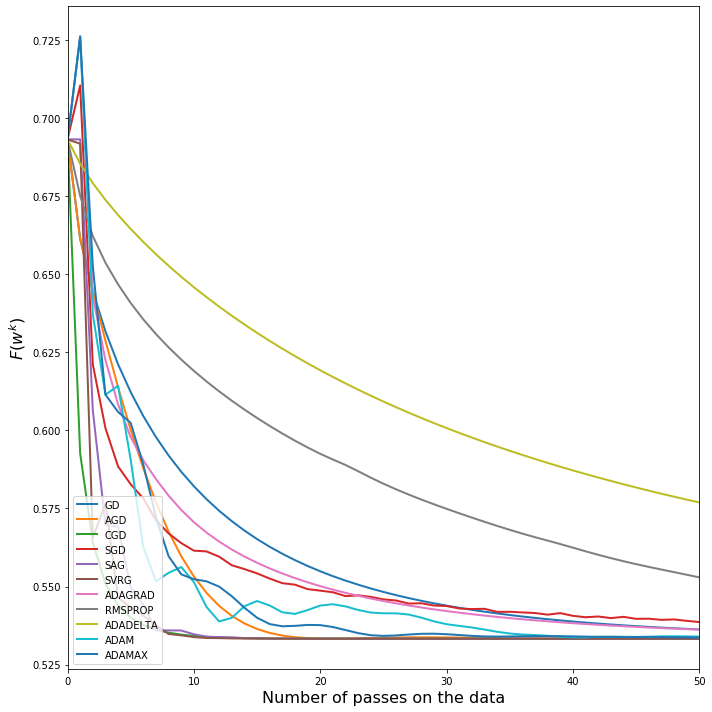

In [56]:
plt.figure(figsize=(10, 10))

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives 
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) $", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()
send(plt, 20)

### What do you think? How can we improve the plot to make it more insightful ?

In [60]:
# 1 . Compute the minimal value of the function by running CGD (or another fast method)
# for 20 times more iterations than any other method

# 2. Set yscale to log

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

<Response [200]>

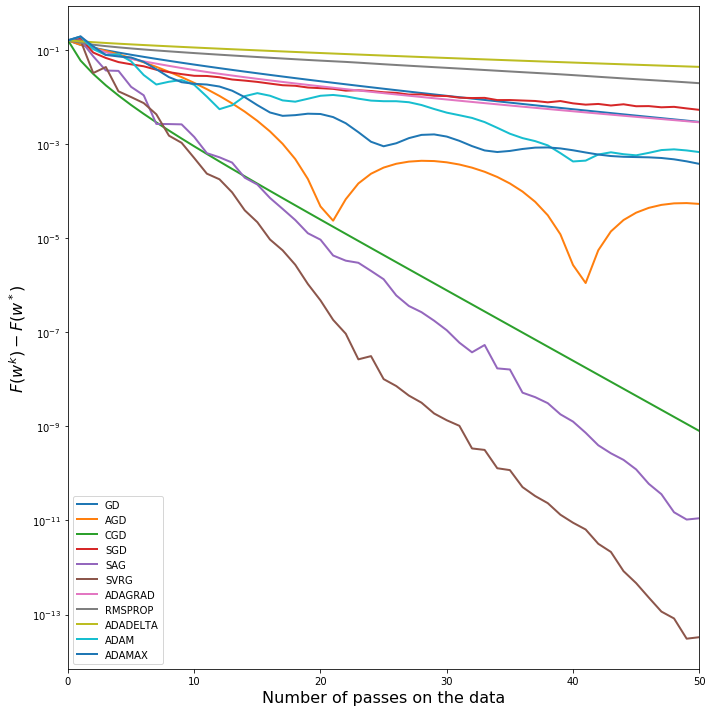

In [61]:
plt.figure(figsize=(10, 10))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()
send(plt, 21)

Try to answer some of the following questions:

- A. What is the speed of convergence  of GD, AGD, SGD (you may need another plot for that)
- B. Compare GD SGD: is there any "best algorithm between GD and SGD"
- C. Compare GD and AGD. Compare the slopes? How does that reflect theory ? What steps did we choose?
- D. Which curve oscillates (i.e., is "bumpy")? check this great blog post on the topic https://distill.pub/2017/momentum/
- E. Tune the step size for GD, SGD, etc. FInd the value of the maximal step size that avoids divergence
- F. Compare the convergence rate for different strategies for SGD (learning rate decay, averaging or not)
- G. Compare the different strategies for the tuning of the momentum coefficient for AGD
- H. What is the impact of Variance reduction. Does it match what is expected?
- I. n logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.
- J. In logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.



### <font color='green'> If you generate interesting plots, share them  !! </font> 

Use 

````send(plt, 30)````

 (with increasing numbers starting at 30)